Importamos las librerias necesarias

In [1]:
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient
from azure.ai.ml import automl

ModuleNotFoundError: No module named 'azure.ai'

Instanciar un cliente de ML con Azure

In [3]:
credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential)

Found the config file in: /config.json


**Descargamos el dataset en la Instance que ejecuta este notebook**

In [1]:
import os
import urllib
from zipfile import ZipFile

# Definimos el directorio en el que se encontrará el dataset
dataset_parent_dir = "./data"

# Crea el folder si este no existe
os.makedirs(dataset_parent_dir, exist_ok=True)

# Descargamos el dataset (zip file)
download_url = "http://dl.dropboxusercontent.com/scl/fi/qjlh5uvhwiaixcmw67fq0/fire_dataset.zip?rlkey=j1j8wdy522dcbp4augpegtpkz&dl=0"

# Definimos el nombre del dataset
dataset_name = "fire_dataset"

# Directorio del dataset = ./data/fire_dataset
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

print(dataset_name)
print(dataset_dir)

fire_dataset
./data/fire_dataset


In [4]:
# Get the data zip file path ./data/fire_dataset.zip
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Descargamos el dataset en data_file = ./data/fire_dataset.zip
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path=dataset_parent_dir)
    print("done")

extracting files...
done


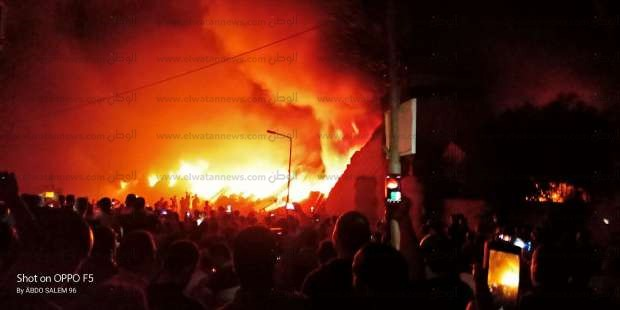

In [5]:
# Mostramos una imagen para verificar que las imagenes hayan sido extraidas apropiadamente y estamos usando la estructura de directorios correcta
from IPython.display import Image
sample_image = os.path.join(dataset_dir, "fire_images", "fire.5.png") #./data/fire_dataset/fire_images/fire.5.png
Image(filename=sample_image)

**Subimos el dataset al Data Blob Storage**

In [3]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml import Input

ModuleNotFoundError: No module named 'azure.ai'

In [7]:
my_data = Data(
    path=dataset_dir,
    type=AssetTypes.URI_FOLDER,
    description="fire and non-fire images",
    name="fire-images",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)


Your file exceeds 100 MB. If you experience low speeds, latency, or broken connections, we recommend using the AzCopyv10 tool for this file transfer.

Example: azcopy copy '/mnt/batch/tasks/shared/LS_root/mounts/clusters/newinstacenotebook/code/Users/johancarlos.bo/image-classification-automl/data/fire_dataset' 'https://projectcompute8417190270.blob.core.windows.net/azureml-blobstore-b2ee0cc4-64c3-4500-9097-b4d1d1adcfee/LocalUpload/2b67a2cb841137e16386a28dd571d104/fire_dataset' 

See https://docs.microsoft.com/azure/storage/common/storage-use-azcopy-v10 for more information.
Uploading fire_dataset (408.78 MBs): 100%|██████████| 408783645/408783645 [00:16<00:00, 24757193.15it/s]




In [9]:
#Verificamos el uri folder donde se subió el folder de imagenes
uri_folder_data_asset.path

'azureml://subscriptions/e9e586c7-142b-4da8-94cc-65b7d2615690/resourcegroups/computer-vision/workspaces/project-computer-vision/datastores/workspaceblobstore/paths/LocalUpload/2b67a2cb841137e16386a28dd571d104/fire_dataset/'

**Creamos el archivo JSONL**

In [10]:
#Instalamos el package para trabajar con jsonlines
!pip install jsonlines

Cambiamos al kernel: _Python 3.8 ML_, ya que en este kernel fue instalado el paquete _jsonlines_  
Sin embargo este kernel no tiene instalado los paquetes del SDk de azure (azure.ai.ml), que si estan instalados en _Python 3.10 - SDK v2_

In [5]:
import os
from PIL import Image
import jsonlines

# Define the directory where your images are located
image_dir = "./data/fire_dataset/"
blob_storage_objects_path='azureml://subscriptions/e9e586c7-142b-4da8-94cc-65b7d2615690/resourcegroups/computer-vision/workspaces/project-computer-vision/datastores/workspaceblobstore/paths/LocalUpload/2b67a2cb841137e16386a28dd571d104/fire_dataset/'

# Define the output JSONL file path
output_jsonl_file = "fire_images_png.jsonl"

# List of classes
classes = ["fire_images", "non_fire_images"]

# Open the JSONL file for writing
with jsonlines.open(output_jsonl_file, mode='w') as writer:
    # Loop through each class directory
    for class_name in classes:
        class_dir = os.path.join(image_dir, class_name)
        # Check if the class directory exists
        if os.path.exists(class_dir) and os.path.isdir(class_dir):
            # List all image files in the class directory
            image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            print(f'images found in {class_dir}: {len(image_files)}')
            # Loop through each image file
            for image_file in image_files:
                # Construct the full image path
                image_path = os.path.join(class_dir, image_file)
                
                # Open the image to get its details
                with Image.open(image_path) as img:
                    image_details = {
                        # "format": img.format,
                        "format": 'png',
                        "width": img.width,
                        "height": img.height
                    }
                img_path_names = image_path.split('/')
                # Create the JSON object for this image
                image_info = {
                    "image_url": f"{blob_storage_objects_path}{img_path_names[-2]}/{img_path_names[-1]}",
                    "image_details": image_details,
                    "label": class_name
                }
                
                # Write the JSON object to the JSONL file
                writer.write(image_info)
        else:
            print(f'directory:{class_dir} does not exists')
print(f"JSONL file '{output_jsonl_file}' has been created.")


images found in ./data/fire_dataset/fire_images: 755
images found in ./data/fire_dataset/non_fire_images: 244
JSONL file 'fire_images_png.jsonl' has been created.
